# Simulation of an insurance company
Simulation of the first and second order reserve and its evolution together with the portfolios performance during different investment strategies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gamma = 0.13638108
alpha = 0.0007915688948559289
beta = 5.91753850547797e-07
gamma = 0.13638108
P = 120_000 #Yearly payment (in)
G0 = 2_000_000
V0 = 2_200_000
x = 60 #The persons age
z = 65 #Retirement age
s = 120-z #Life long payments
u = z-x #Years until retirement
b_y = 166403.96768391522 #Yearly payment (out)
p = 120_000/12
b = b_y / 12
s_y = 0.02
s_m = 1- ((1-s_y)**(1/12))
r_p = 0.02 #prognosis rate
delta_p = np.log(1+r_p)


<Axes: >

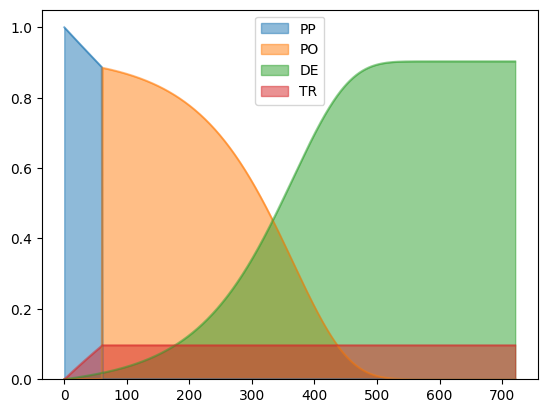

In [ ]:
#r_p = prognosis rate 
states = [[0,0,0,0]]
states[0][0] = 1
t_pp_tr_vec = []

#months = range(1,601)
months = np.linspace(0,60,12*60+1)

def get_l_next(t):
    l_x_next =  np.exp(-alpha*(x+t) - (beta/gamma)*(np.exp(gamma*(x+t))-1))
    return l_x_next

for i,t in enumerate(months): 
    l_x = get_l_next(t)
    l_next = get_l_next(t+1/12)
    q_x = 1 - (l_next/l_x)

    t_pp_de = states[i][0] * q_x
    t_po_de = states[i][1] * q_x
    t_pp_tr = (states[i][0]-t_pp_de)*s_m    
    t_pp_po = states[i][0] - t_pp_de - t_pp_tr if t==u else 0
    t_pp_tr_vec.append(t_pp_tr)
    #Updating states
    new_state = list()
    new_state.append(states[i][0]-t_pp_de-t_pp_tr-t_pp_po) #if t <= u+1/12 else new_state.append(0)
    new_state.append(states[i][1]-t_po_de+t_pp_po)
    new_state.append(states[i][2]+t_pp_de+t_po_de)
    new_state.append(states[i][3]+t_pp_tr)
    states.append(new_state)

states = pd.DataFrame(states, columns=["PP","PO","DE","TR"])
states.iloc[:,:600].plot.area(stacked=False)


## For Longevity risk
How the distribution would look if people live longer.

<Axes: >

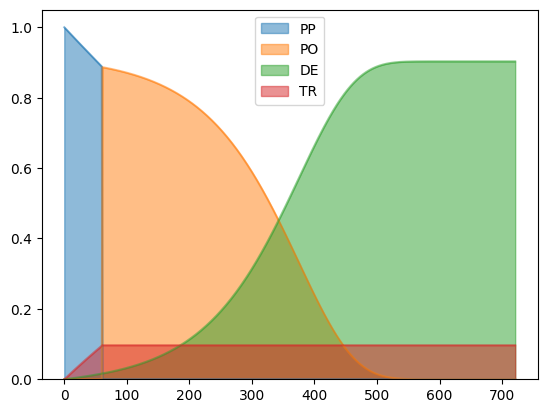

In [3]:

#r_p = prognosis rate i föreläsningen
states_lon = [[0,0,0,0]]
states_lon[0][0] = 1
t_pp_tr_vec_lon = []

#months = range(1,601)
months = np.linspace(0,60,12*60+1)
def get_l_next_SCR(t):
    alpha_SCR = 0.9*alpha
    beta_SCR = 0.9*beta
    l_x_next =  np.exp(-alpha_SCR*(x+t) - (beta_SCR/gamma)*(np.exp(gamma*(x+t))-1))
    return l_x_next

for i,t in enumerate(months): 
    l_x = get_l_next_SCR(t)
    l_next = get_l_next_SCR(t+(1/12))
    q_x = 1 - (l_next/l_x)
    t_pp_de_lon = states_lon[i][0] * q_x
    t_po_de_lon = states_lon[i][1] * q_x
    t_pp_tr_lon = (states_lon[i][0]-t_pp_de_lon)*s_m    
    t_pp_po_lon = states_lon[i][0] - t_pp_de_lon - t_pp_tr_lon if t==u else 0
    t_pp_tr_vec_lon.append(t_pp_tr_lon)
    #Updating states
    new_state = list()
    new_state.append(states_lon[i][0]-t_pp_de_lon-t_pp_tr_lon-t_pp_po_lon) #if t <= u+1/12 else new_state.append(0)
    new_state.append(states_lon[i][1]-t_po_de_lon+t_pp_po_lon)
    new_state.append(states_lon[i][2]+t_pp_de_lon+t_po_de_lon)
    new_state.append(states_lon[i][3]+t_pp_tr_lon)
    states_lon.append(new_state)

states_lon = pd.DataFrame(states_lon, columns=["PP","PO","DE","TR"])
states_lon.iloc[:,:600].plot.area(stacked=False)


In [ ]:

# Read the CSV file
# The file contains different scenarios for stock price movements and bond yield movements for 
# bond with different maturities
data = pd.read_csv("ScenarioFile.csv", sep=",")


data = data.drop(data.columns[0], axis=1)

#print(data.head())


# Splitting the data into scenarios
scenarios = data['Scenario'].unique()

scenario_dfs = {scenario: data[data['Scenario'] == scenario] for scenario in scenarios}

scenario_1_df = scenario_dfs[1]
print(scenario_1_df.iloc[1,2:3]) 


BA    244.680237
Name: 1, dtype: float64


### First Order Reserve

13866.997306992935
13866.997306992935


Text(0.5, 1.0, 'Evolution of the 1:st reserve')

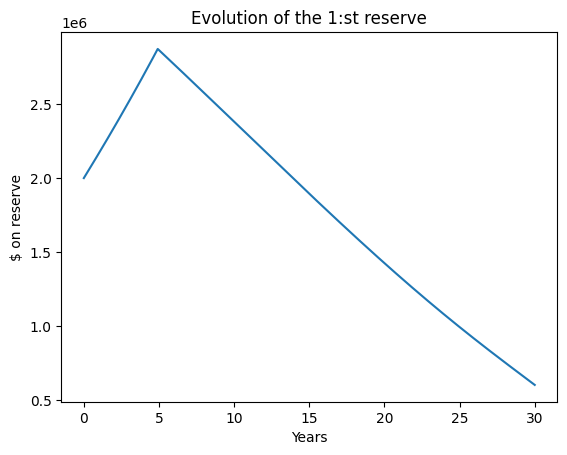

In [5]:

r_G = 0.02

time = np.arange(1,721)/12
#time = np.linspace(0,60,12*60+1)


def get_l_next(t, alpha, beta, gamma):
    alpha = alpha 
    beta = beta 

    return np.exp(-alpha * t - (beta / gamma) * (np.exp(gamma * t) - 1))

def get_l_next_SCR(t,alpha,beta,gamma):
    alpha_SCR = 0.9*alpha
    beta_SCR = 0.9*beta
    l_x_next =  np.exp(-alpha_SCR*(t) - (beta_SCR/gamma)*(np.exp(gamma*(t))-1))
    return l_x_next

def first_reserve(func,SCR):
    reserve1=[]
    reserve1.append(G0)

    cf1 = np.zeros(len(time)+1)
    cf1[0] = -10000
    E_Gt = np.zeros(len(time)+1)    
    E_Gt[0] = G0*(states["PP"][0] + states["PO"][0])
    
    
    
    for i,t in enumerate(time):
        
        
        l_x = func(x+(i/12),alpha,beta,gamma)
        l_next = func(x+((i+1)/12), alpha, beta,gamma)
        q_x = 1 - (l_next/l_x)
        if x+t < z:
            premie = p

            #q_x = 1 - (l_next/l_x)
            risk_premie = -(q_x / (1-q_x))*reserve1[i]
            portfolio_return = reserve1[i]*((1+r_G)**(1/12)-1)
            #tr = (states["TR"][i+1] - states["TR"][i])

            tr = t_pp_tr_vec[i]
            #tr_lon = (states_lon["TR"][i+1] - states_lon["TR"][i])
            tr_lon = t_pp_tr_vec_lon[i]
            G_next = reserve1[i] + premie - risk_premie + portfolio_return
            reserve1.append(G_next)
        else:

            # q_x = 1 - (l_next/l_x)
            tr = 0
            tr_lon = 0
            risk_premie = -(q_x / (1-q_x))*reserve1[i]
            portfolio_return = reserve1[i]*((1+r_G)**(1/12)-1)
            payment = b
            G_next = reserve1[i] - risk_premie + portfolio_return - payment
            reserve1.append(G_next)
        E_Gt[i+1] = reserve1[-1]*(states["PO"][i]+states["PP"][i])

        if not SCR:
            cf1[i+1] = states["PO"][i+1]*b +  tr*reserve1[-1] - states["PP"][i+1]*p
        else:
            cf1[i+1] = states_lon["PO"][i+1]*b + tr_lon*reserve1[-1] - states_lon["PP"][i+1]*p
    print(b)
    if SCR:
        return cf1, reserve1
    else:
        return cf1, reserve1, E_Gt
    

cf1, reserve1, E_Gt = first_reserve(get_l_next, False)
cf1_longe, reserve1_longe = first_reserve(get_l_next_SCR, True)
plt.plot(np.linspace(0,30,12*30+1),reserve1[:30*12+1])
plt.ylabel("$ on reserve")
plt.xlabel("Years")
plt.title("Evolution of the 1:st reserve")


### Second Order Reserve

In [ ]:

def second_reserve(SCR, port_ret, period, V):
    if SCR == False:
        l_x = get_l_next(x+((period-1)/12),alpha,beta,gamma)
        l_next = get_l_next(x+(period/12),alpha,beta,gamma)
        if x+period/12 <= z:
            #Premie and riskpremie
            B = 0
            payment=0
            premie = p
            q_x = 1 - (l_next/l_x)
            risk_premie2 = -(q_x / (1-q_x))*V
            portfolio_return = port_ret

            tr = (states["TR"][period] - states["TR"][period-1])
            V_next = V + premie - risk_premie2 + portfolio_return
        else:
            tr=0
            q_x = 1 - (l_next/l_x)
            risk_premie2 = -(q_x / (1-q_x))*V
            portfolio_return = port_ret
            premie = 0
            tau = np.arange(0,12*(z+s-(x+period/12))+1,1)
            lx = get_l_next(x+period/12, alpha,beta,gamma)
            l_x_tau = get_l_next(x+period/12 + tau/12,alpha,beta,gamma)
            term1 = l_x_tau / lx
            term2 = term1 * np.exp(-delta_p * (tau/12))

            B = (V+portfolio_return-risk_premie2)/np.sum(term2) #12 ska inte vara med då vi vill se måndasvis utbetalning!!!
            payment = b if B < b else B


            V_next = V - risk_premie2 + portfolio_return - payment
    else:
        l_x = get_l_next_SCR(x+(period/12),alpha,beta,gamma)
        l_next = get_l_next_SCR(x+(period/12)+(1/12),alpha,beta,gamma)
        if x+period/12 < z:
            #Premie and riskpremie
            B = 0
            payment=0
            premie = p
            q_x = 1 - (l_next/l_x)
            risk_premie2 = -(q_x / (1-q_x))*V
            portfolio_return = port_ret

            tr = (states_lon["TR"][period] - states_lon["TR"][period-1])
            V_next = V + premie - risk_premie2 + portfolio_return
        else:
            tr=0
            q_x = 1 - (l_next/l_x)
            risk_premie2 = -(q_x / (1-q_x))*V
            portfolio_return = port_ret
            premie = 0
            tau = np.arange(0,12*(z+s-(x+period/12))+1,1)
            lx = get_l_next_SCR(x+period/12,alpha,beta,gamma)
            l_x_tau = get_l_next_SCR(x+period/12 + tau/12,alpha,beta,gamma)
            term1 = l_x_tau / lx
            term2 = term1 * np.exp(-delta_p * (tau/12))

            B = (V+portfolio_return-risk_premie2)/np.sum(term2) #12 ska inte vara med då vi vill se måndasvis utbetalning!!!
            payment = b if B < b else B


            V_next = V - risk_premie2 + portfolio_return - payment
    
    if SCR == False:
        cf2 = states["PO"][period]*B - states["PP"][period]*premie + tr * np.maximum(reserve1[period-1], V) 
    else:
        cf2 = states_lon["PO"][period]*B - states_lon["PP"][period]*premie + tr * np.maximum(reserve1[period-1], V) 

    return V_next, cf2 

In [ ]:
# Calculating the Nelson-Siegel parameters
def NS(months, period, B1, B2, B3):
    lamb = 0.7308
    t = np.arange(1, months - period + 1) / 12  
    term1 = (1 - np.exp(-lamb * t)) / (lamb * t) 
    term2 = np.exp(-lamb * t)  
    r_T = B1 + B2 * term1 + B3 * (term1 - term2) 

    return np.array(r_T)

In [ ]:
# Calculating the portfolio duration
def duration(period,r_T,t):
    above = np.sum(t*cf1[period+1:]*np.exp(-r_T*t))
    bottom = np.sum(cf1[period+1:]*np.exp(-r_T*t))

    return above/bottom

In [ ]:
# Calculating the portfolio value
def calculator(filename, SCR, weights, months, strategy):
    data = pd.read_csv(filename, sep=",") # byt till filename
    if filename == "ScenarioFile.csv":
        data = data.drop(data.columns[0], axis=1)
    if filename == "OwnScenario2.csv":
        data = data.drop(data.columns[-5:], axis=1)
    uniq_scenarios = data['Scenario'].unique()


    scenarios = {scenario: data[data['Scenario'] == scenario] for scenario in uniq_scenarios}

    solvent = np.zeros((len(uniq_scenarios),months+1))
    BE = np.zeros((len(uniq_scenarios),months+1))
    BOF = np.zeros((len(uniq_scenarios),months+1))


    global CPPI_allocations
    CPPI_allocations = np.zeros((4,months+1))
    portfolio_value = np.zeros((len(uniq_scenarios), months+1)) 
    portfolio_value[:,0] = V0
    exp_v_vec = np.zeros((len(uniq_scenarios), months+1))
    
    if not SCR:
        exp_v_vec[:,0] = V0*(states["PO"][0] + states["PP"][0])
    else:
        exp_v_vec[:,0] = V0*(states_lon["PO"][0] + states_lon["PP"][0])
        
    for scenario in scenarios:
        T = np.arange(1,len(cf1))/12
        #First value
        betas = scenarios[scenario].iloc[0,-3:]
        r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])


        if not SCR:
            BE[scenario-1,0] = np.sum(cf1[1:]*np.exp(-r_T*T))
        else: 
            BE[scenario-1,0] = np.sum(cf1_longe[1:]*np.exp(-r_T*T))

        BOF[scenario-1,0] = portfolio_value[scenario-1,0]-BE[scenario-1,0]
        solvent[scenario-1, 0] = BOF[scenario-1, 0]>0
 
        if strategy == "CM_d":
            stock_w = [1/20 for i in range(10)]
            dur = duration(0,r_T, T)
            if dur <= 5:
                x = [[1],[0]]
            elif dur >= 30:
                x = [[0],[1]]
            else:
                A = np.array([[1,1],[5,30]])
                c = np.array([[1], [dur]])
                x = np.linalg.solve(A,c)
            bond_w = [0.5*x[0][0], 0, 0, 0, 0.5*x[1][0]]
            weights = np.array(stock_w+bond_w)
        
        elif strategy == "CPPI":
            m = 2
            C = m*BOF[scenario-1,0]
            stock_prop = np.minimum(C/(BOF[scenario-1,0]+BE[scenario-1,0]),1)
            stock_w = [stock_prop*1/10 for i in range(10)]
            dur = duration(0,r_T, T)
            A = np.array([[1,1],[5,30]])
            c = np.array([[1], [dur]])
            x = np.linalg.solve(A,c)
            bond_prop = 1-stock_prop
            bond_w = [bond_prop*x[0][0], 0, 0, 0, bond_prop*x[1][0]]
            weights = np.array(stock_w+bond_w)
            if scenario == 35:
                CPPI_allocations[0,0] = stock_prop
                CPPI_allocations[1,0] = bond_prop
            elif scenario == 208:
                CPPI_allocations[2,0] = stock_prop
                CPPI_allocations[3,0] = bond_prop
        
        P2 = V0*weights
        V = V0*weights

        
        for period in range(1,len(scenarios[scenario]))[:months]:
            betas = scenarios[scenario].iloc[period,-3:]
            B1, B2, B3 = betas[0], betas[1], betas[2]

            r_T = NS(len(cf1)-1, period, B1, B2, B3)
            T = np.arange(1,len(cf1)-period)/12

            P1 = P2*np.array(((scenarios[scenario].iloc[period,2:-3])/scenarios[scenario].iloc[period-1,2:-3])) 

            port_ret = np.sum(P1)/np.sum(P2)-1
            port_ret_dollar = port_ret * np.sum(V)#*portfolio_value[scenario-1,period-1]
            V_next, cf2 = second_reserve(SCR, port_ret_dollar, period, np.sum(V))

            if not SCR:
                exp_v_vec[scenario-1,period] = V_next * (states["PP"][period] + states["PO"][period])
            else:
                exp_v_vec[scenario-1,period] = V_next * (states_lon["PP"][period] + states_lon["PO"][period])

            P2 = P1 + (-cf2)*(P1/np.sum(P1))
            #portfolio_value.append(Assets_next)
            portfolio_value[scenario-1,period] = np.sum(P2)#portfolio_value[scenario-1,period-1]*(1+port_ret)-cf2
            #T = np.linspace(1/12,(length-period-1)/12+1/12,(len(cf1)-period))

            if not SCR:
                BE[scenario-1,period] = np.sum(cf1[period+1:]*np.exp(-r_T*T))

            else:
                BE[scenario-1,period] = np.sum(cf1_longe[period+1:]*np.exp(-r_T*T))

            BOF[scenario-1, period] = portfolio_value[scenario-1,period] - BE[scenario-1,period]
            
            if solvent[scenario-1, period-1] == True:
                solvent[scenario-1, period] = BOF[scenario-1, period] > 0
            else:
                solvent[scenario-1, period] = False
                
            if strategy == "BH":

                pass
            
            elif strategy == "CM":
                P2 = np.sum(P2)*weights
                
                
            elif strategy == "CM_d":
                dur = duration(period,r_T,T)
                if dur <= 5:
                    x = [1,0]
                elif dur >= 30:
                    x = [0,1]
                else:    

                    x = np.zeros(2)
                    x[0] = (dur - 30) / (5-30)
                    x[1] = 1 - x[0]
                bond_w = [0.5*x[0], 0, 0, 0, 0.5*x[1]]
                weights = np.array(stock_w+bond_w)
                P2 = np.sum(P2)*weights
                
            elif strategy == "CPPI":
                m = 2
                C = m*BOF[scenario-1,period]
                stock_prop = np.maximum(0,np.minimum(C/(BOF[scenario-1,period]+BE[scenario-1,period]),1))
                stock_w = [stock_prop*1/10 for i in range(10)]
                dur = duration(period,r_T,T)
                if dur <= 5:
                    x = [1,0]
                elif dur >= 30:
                    x = [0,1]
                else:

                    x = np.zeros(2)
                    x[0] = (dur - 30) / (5-30)
                    x[1] = 1 - x[0]
                bond_prop = 1-stock_prop
                bond_w = [bond_prop*x[0], 0, 0, 0, bond_prop*x[1]]
                weights = np.array(stock_w+bond_w)
                P2 = np.sum(P2)*weights
                if scenario == 35:
                    CPPI_allocations[0,period] = stock_prop
                    CPPI_allocations[1,period] = bond_prop
                elif scenario == 208:
                    CPPI_allocations[2,period] = stock_prop
                    CPPI_allocations[3,period] = bond_prop



            else:
                print("ingen strategi")

            V = V_next
    return portfolio_value, exp_v_vec, BE, BOF, solvent


#Equal weights
stock_w = [1/10 for i in range(10)]
bond_w = [0 for i in range(5)]
weights = np.array(stock_w+bond_w)
months = 12*30
portfolio, E_Vt, BE, BOF, solvent = calculator("OneScenario.csv", False, weights, months, "CM")
portfolio_longe, E_Vt_longe, BE_longe, BOF_longe, solvent_longe = calculator("OneScenario.csv", True, weights, months, "CM")

C:\Users\chril\AppData\Local\Temp\ipykernel_36216\2996520638.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_36216\2996520638.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]
C:\Users\chril\AppData\Local\Temp\ipykernel_36216\2996520638.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_

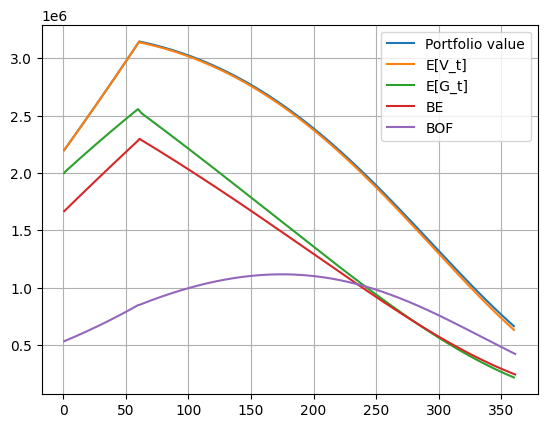

In [10]:
plt.plot(np.linspace(1,12*30,12*30+1), portfolio[0,:12*30+1], label = "Portfolio value")
plt.legend()
plt.plot(np.linspace(1,12*30,12*30+1), E_Vt[0,:12*30+1], label = "E[V_t]")
plt.legend()
plt.plot(np.linspace(1,12*30,12*30+1), E_Gt[:12*30+1], label = "E[G_t]")
plt.legend()
plt.plot(np.linspace(1,12*30+1,12*30+1), BE[0,:], label = "BE")
plt.legend()
plt.plot(np.linspace(1,12*30+1,12*30+1), BOF[0,:], label = "BOF")
plt.legend()
#plt.plot(np.linspace(1,12*30,12*30+1), portfolio_longe[0,:12*30+1], label = "Portfolio value Longevity")
#plt.legend()
plt.grid()
# plt.plot(np.linspace(1,12*30+1,12*30+1), BOF_longe[0,:], label = "BOF_longevity")
# plt.legend()


In [11]:
years = []
E_V = []
E_G = []
port = []
BE_lista = []
BOF_lista = []

for i, amount in enumerate(portfolio[0,:]):
    if i % 60 == 0 :  # Every 60 months (5 years)
        years.append(i // 12)  # Convert months to years
        E_V.append(E_Vt[0,i])  # Get the reserve at that point
        E_G.append(E_Gt[i])
        port.append(amount)
        BE_lista.append(BE[0,i])
        BOF_lista.append(BOF[0,i])
    if i == 360:
        break
#print(BOF[::60])
# Create a dictionary with the two lists
data = {'Year': years, 'E_V': E_V, "E_G":E_G, "portfolio":port,"BE":BE_lista, "BOF":BOF_lista}

df = pd.DataFrame(data)
pd.options.display.float_format = '{:.0f}'.format
print(df)
pd.reset_option('display.float_format') 


   Year     E_V     E_G  portfolio      BE     BOF
0     0 2200000 2000000    2200000 1667210  532790
1     5 3145635 2544801    3147191 2297876  849316
2    10 2925605 2038536    2934816 1882944 1051872
3    15 2539997 1523963    2552541 1437610 1114931
4    20 1978768 1017370    1996021  984409 1011611
5    25 1294841  561902    1318600  565777  752823
6    30  631145  215923     663426  242018  421408


## For Longevity

In [ ]:
from scipy.stats import norm
phi = norm.ppf(0.995)
delta_BOF_longe = (BOF - BOF_longe)

print("SCR for longevity is: ",round(BOF[0,0] - BOF_longe[0,0],2))

SCR for longevity is:  50078.07


### Testing if the insurance company would stay solvent during extreme events with different investment strategies
 

Testing the strategy BH(100/0) (Buy and hold)

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


SCR BH(0/100): 142041.45656142602


(-500000.0, 3500000.0)

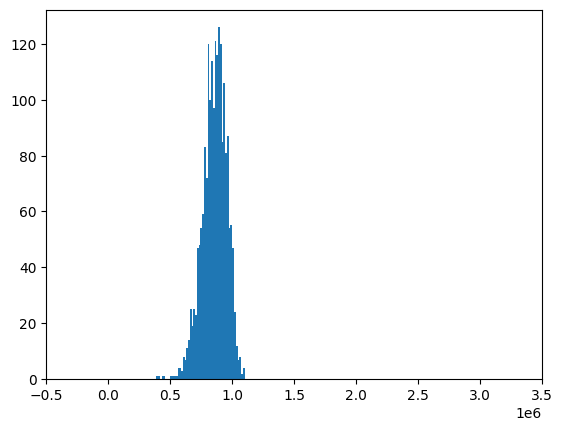

In [495]:
stock_w = [0 for i in range(10)]
bond_w = [0,0,1,0,0]
weights = np.array(stock_w+bond_w)
months = 12*1
portfolio, E_Vt, BE, BOF, solvent = calculator("ScenarioFile.csv", False, weights, months, "BH")
#portfolio_SCR, E_Vt_SCR, BE_SCR, BOF_SCR, solvent_SCR = calculator("ScenarioFile.csv", True, weights, months, "BH")

BOF = pd.DataFrame(BOF)



delta_BOF = BOF.iloc[:,0] - BOF.iloc[:,12]

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
VaR_BH_0_100 = np.percentile(delta_BOF, 95)

print("SCR BH(0/100):", VaR_BH_0_100)

plt.hist(BOF.iloc[:,12], bins=50)
plt.xlim((-500_000, 3_500_000))

Testing the strategy BH(50/50) (Buy and hold)

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


SCR BH(50/50) 345792.2052906548


(-500000.0, 3500000.0)

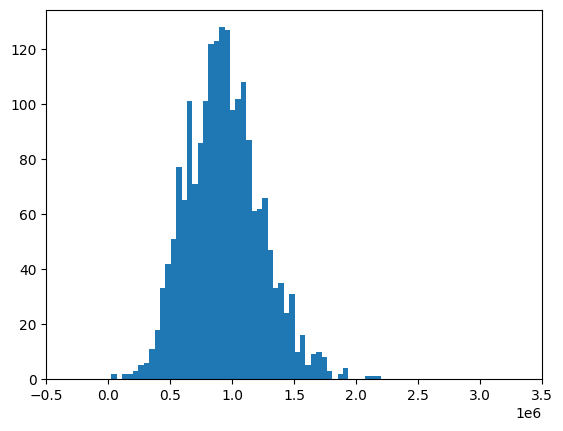

In [496]:

stock_w = [1/20 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/2,0,0,0,0]
weights = np.array(stock_w+bond_w)
months = 12*1
portfolio, E_Vt, BE, BOF, solvent = calculator("ScenarioFile.csv", False, weights, months, "BH")
#portfolio_SCR, E_Vt_SCR, BE_SCR, BOF_SCR, solvent_SCR = calculator("ScenarioFile.csv", True, weights, months, "BH")


BOF = pd.DataFrame(BOF)



delta_BOF = BOF.iloc[:,0] - BOF.iloc[:,12]

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
VaR_BH_50_50 = np.percentile(delta_BOF, 95)

print("SCR BH(50/50)", VaR_BH_50_50)

plt.hist(BOF.iloc[:,12], bins=50)
plt.xlim((-500_000, 3_500_000))

Testing the strategy CM(50/50) (Constant Mix)

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


SCR CM(50/50) : 343108.6494014974


(-500000.0, 3500000.0)

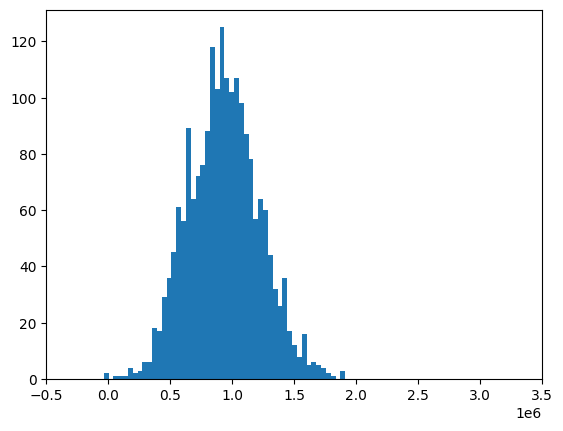

In [497]:
stock_w = [1/20 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/2,0,0,0,0]
weights = np.array(stock_w+bond_w)
months = 12*1
portfolio, E_Vt, BE, BOF, solvent = calculator("ScenarioFile.csv", False, weights, months, "CM")
#portfolio_SCR, E_Vt_SCR, BE_SCR, BOF_SCR, solvent_SCR = calculator("ScenarioFile.csv", True, weights, months, "CM")


BOF = pd.DataFrame(BOF)



delta_BOF = BOF.iloc[:,0] - BOF.iloc[:,12]

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
VaR_CM_50_50 = np.percentile(delta_BOF, 95)

print("SCR CM(50/50) :",VaR_CM_50_50)
plt.hist(BOF.iloc[:,12], bins=50)
plt.xlim((-500_000, 3_500_000))

Testing the strategy CM(50/50) with duration matching with the liabilities

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


SCR CM_d(50/50) : 237215.55814898663


(-500000.0, 3500000.0)

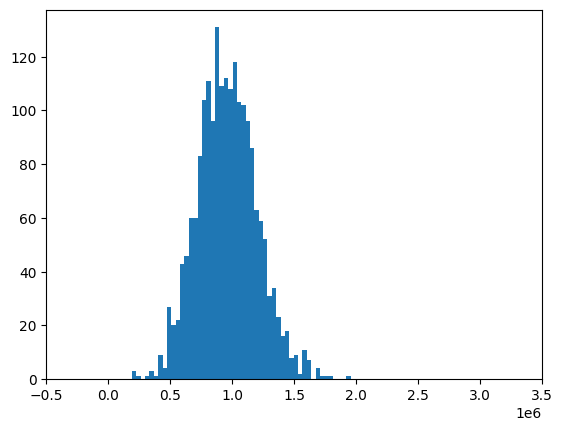

In [498]:
stock_w = [1/12 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/12,0,0,0,1/12]
weights = np.array(stock_w+bond_w)
months = 12*1

portfolio, E_Vt, BE, BOF, solvent = calculator("ScenarioFile.csv", False, weights, months, "CM_d")


BOF = pd.DataFrame(BOF)



delta_BOF = BOF.iloc[:,0] - BOF.iloc[:,12]

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
VaR_CM_d_50_50 = np.percentile(delta_BOF, 95)

print("SCR CM_d(50/50) :", VaR_CM_d_50_50)

plt.hist(BOF.iloc[:,12], bins=50)
plt.xlim((-500_000, 3_500_000))
#237215

Testing the strategy CPPI(2) (Constant Proportion Portfolio Insurance)

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


SCR CPPI(2) : 351925.77175202523


(-500000.0, 3500000.0)

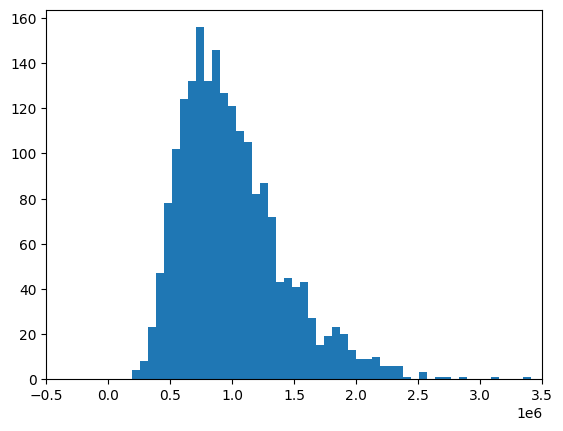

In [499]:

stock_w = [1/12 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/12,0,0,0,1/12]
weights = np.array(stock_w+bond_w)
months = 12*1

portfolio, E_Vt, BE, BOF, solvent = calculator("ScenarioFile.csv", False, weights, months, "CPPI")


BOF = pd.DataFrame(BOF)



delta_BOF = BOF.iloc[:,0] - BOF.iloc[:,12]

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
VaR_CPPI_2 = np.percentile(delta_BOF, 95)

print("SCR CPPI(2) :", VaR_CPPI_2)

plt.hist(BOF.iloc[:,12], bins=50)
plt.xlim((-500_000, 3_500_000))

# Testing the strategies during multiple scenarios

### BH(0/100)

In [500]:
stock_w = [0 for i in range(10)]
bond_w = [0,0,1,0,0]
weights = np.array(stock_w+bond_w)
months = 12*10
portfolio_a, E_Vt_a, BE_a, BOF_a, solvent_a = calculator("ScenarioFile.csv", False, weights, months, "BH")
#portfolio_SCR, E_Vt_SCR, BE_SCR, BOF_SCR, solvent_SCR = calculator("ScenarioFile.csv", True, weights, months, "BH")

BOF_a = pd.DataFrame(BOF_a)



delta_BOF_a = BOF_a.diff(axis=1).dropna(axis=1)

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
VaR_BH_0_100 = np.percentile(delta_BOF_a, 95)

VaR_BH_0_100


# SCR = pd.DataFrame(mean_loss)
# SCR
#83300

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


115919.08650077891

### BH(50/50)

In [501]:
stock_w = [1/20 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/2,0,0,0,0]
weights = np.array(stock_w+bond_w)
months = 12*10
portfolio_b, E_Vt_b, BE_b, BOF_b, solvent_b = calculator("ScenarioFile.csv", False, weights, months, "BH")
#portfolio_SCR, E_Vt_SCR, BE_SCR, BOF_SCR, solvent_SCR = calculator("ScenarioFile.csv", True, weights, months, "BH")


BOF_b = pd.DataFrame(BOF_b)



#delta_BOF_b = BOF_b.diff(axis=1).dropna(axis=1)

#scenarios_losses = np.sum(delta_BOF, axis=1)
#VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
#VaR_BH_50_50 = np.percentile(delta_BOF_b, 95)

#VaR_BH_50_50

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


### CM(50/50)

In [502]:
stock_w = [1/20 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/2,0,0,0,0]
weights = np.array(stock_w+bond_w)
months = 12*10
portfolio_c, E_Vt_c, BE_c, BOF_c, solvent_c = calculator("ScenarioFile.csv", False, weights, months, "CM")
#portfolio_SCR, E_Vt_SCR, BE_SCR, BOF_SCR, solvent_SCR = calculator("ScenarioFile.csv", True, weights, months, "CM")


BOF_c = pd.DataFrame(BOF_c)



# delta_BOF_c = BOF_c.diff(axis=1).dropna(axis=1)

# #scenarios_losses = np.sum(delta_BOF, axis=1)
# #VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
# VaR_CM_50_50 = np.percentile(delta_BOF_c, 95)

# VaR_CM_50_50

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


### CM(50/50) duration matching

In [503]:
stock_w = [1/12 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/12,0,0,0,1/12]
weights = np.array(stock_w+bond_w)
months = 12*10

portfolio_d, E_Vt_d, BE_d, BOF_d, solvent_d = calculator("ScenarioFile.csv", False, weights, months, "CM_d")


BOF_d = pd.DataFrame(BOF_d)



# delta_BOF_d = BOF_d.diff(axis=1).dropna(axis=1)

# #scenarios_losses = np.sum(delta_BOF, axis=1)
# #VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
# VaR_CM_d_50_50 = np.percentile(delta_BOF_d, 95)

# VaR_CM_d_50_50


C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


### CPPI(2)

In [504]:
stock_w = [1/12 for i in range(10)]
#bond_w = [1/5 for i in range(5)]
bond_w = [1/12,0,0,0,1/12]
weights = np.array(stock_w+bond_w)
months = 12*10

portfolio_e, E_Vt_e, BE_e, BOF_e, solvent_e = calculator("ScenarioFile.csv", False, weights, months, "CPPI")


BOF_e = pd.DataFrame(BOF_e)



# delta_BOF_e = BOF_e.diff(axis=1).dropna(axis=1)

# #scenarios_losses = np.sum(delta_BOF, axis=1)
# #VaR_BH_0_100 = np.percentile(scenarios_losses, 95)
# VaR_CPPI_2 = np.percentile(delta_BOF_e, 95)

# VaR_CPPI_2

C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_T = NS(len(cf1)-1,0,betas[0],betas[1],betas[2])
C:\Users\chril\AppData\Local\Temp\ipykernel_28024\3723599711.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  B1, B2, B3 = betas[0], betas[1], betas[2]


### Calculations

          Probability        Median
Strategy                           
A               0.130  1.138374e+06
B               0.047  2.507395e+06
C               0.050  2.314357e+06
D               0.027  2.438238e+06
E               0.012  2.669191e+06


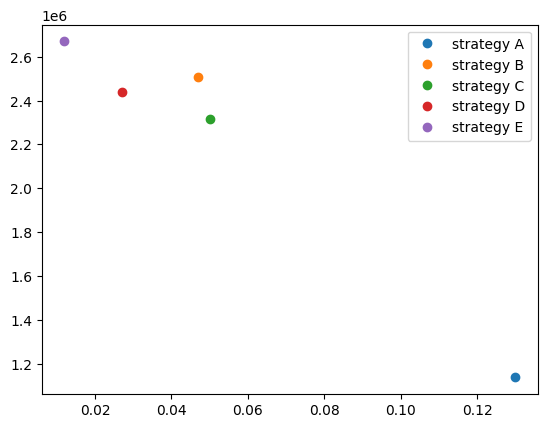

In [ ]:

# med1 = np.median(BOF_a.loc[np.all(solvent_a[:,-1] == True), BOF_a.iloc[:,-1]])
# med2 = np.median(BOF_b.loc[np.all(solvent_b[:,-1] == True), BOF_b.iloc[:,-1]])
# med3 = np.median(BOF_c.loc[np.all(solvent_c[:,-1] == True), BOF_c.iloc[:,-1]])
# med4 = np.median(BOF_d.loc[np.all(solvent_d[:,-1] == True), BOF_d.iloc[:,-1]])
# med5 = np.median(BOF_e.loc[np.all(solvent_e[:,-1] == True), BOF_e.columns[:,-1]])
BOF_a["solvent"] = solvent_a[:,-1]
BOF_b["solvent"] = solvent_b[:,-1]
BOF_c["solvent"] = solvent_c[:,-1]
BOF_d["solvent"] = solvent_d[:,-1]
BOF_e["solvent"] = solvent_e[:,-1]

med1 = np.median(BOF_a.loc[BOF_a["solvent"] == 1, BOF_a.columns[120]])
med2 = np.median(BOF_b.loc[BOF_b["solvent"] == 1, BOF_b.columns[120]])
med3 = np.median(BOF_c.loc[BOF_c["solvent"] == 1, BOF_c.columns[120]])
med4 = np.median(BOF_d.loc[BOF_d["solvent"] == 1, BOF_d.columns[120]])
med5 = np.median(BOF_e.loc[BOF_e["solvent"] == 1, BOF_e.columns[120]])

prob1 = 1- (np.sum(solvent_a[:,-1]))/solvent_a.shape[0]
prob2 = 1- (np.sum(solvent_b[:,-1]))/solvent_b.shape[0]
prob3 = 1- (np.sum(solvent_c[:,-1]))/solvent_c.shape[0]
prob4 = 1- (np.sum(solvent_d[:,-1]))/solvent_d.shape[0]
prob5 = 1- (np.sum(solvent_e[:,-1]))/solvent_e.shape[0]


#print(len(BOF_a.loc[np.all(solvent_a == True, axis=1)]))
medians = np.array([med1, med2, med3, med4, med5])
probabilities = np.array([prob1, prob2, prob3, prob4, prob5])
strategy = np.array(["A","B","C","D","E"])

tabell = {'Strategy': strategy, 'Probability': probabilities, 'Median': medians}
df = pd.DataFrame(tabell).set_index("Strategy")

# Display the table
print(df)
#np.all(solvent_a == True, axis=1)
# plt.plot(probabilities, medians, "o", color="red")
plt.plot(prob1, med1, "o", label="strategy A")
plt.legend()

plt.plot(prob2, med2, "o", label="strategy B")
plt.legend()

plt.plot(prob3, med3, "o", label="strategy C")
plt.legend()

plt.plot(prob4, med4, "o", label="strategy D")
plt.legend()

plt.plot(prob5, med5, "o", label="strategy E")
plt.legend()

## Visualizing the performances for some of the scenarios
### Scenario 35

<Figure size 1200x800 with 0 Axes>

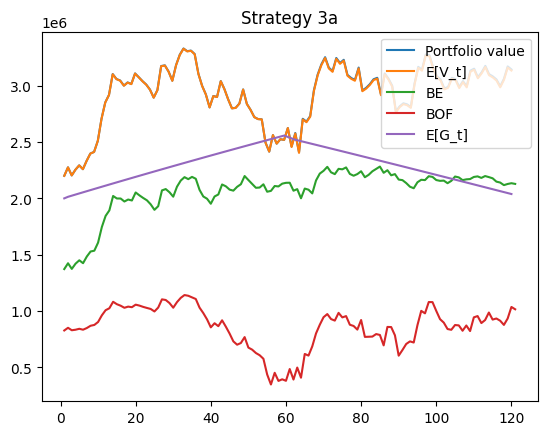

<Figure size 1200x800 with 0 Axes>

In [506]:
key = 34
plt.title("Strategy 3a")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_a[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_a[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_a[key,:], label = "BE")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_a.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper right")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

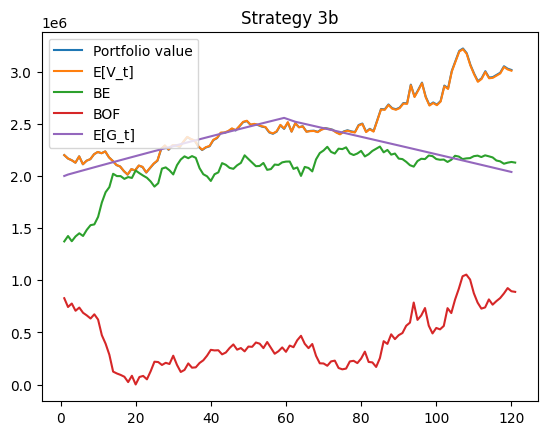

<Figure size 1200x800 with 0 Axes>

In [507]:
key = 34
plt.title("Strategy 3b")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_b[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_b[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_b[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_b.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

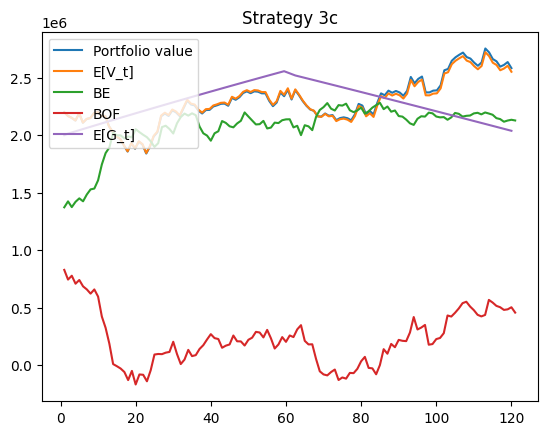

<Figure size 1200x800 with 0 Axes>

In [508]:
key = 34
plt.title("Strategy 3c")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_c[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_c[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_c[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_c.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

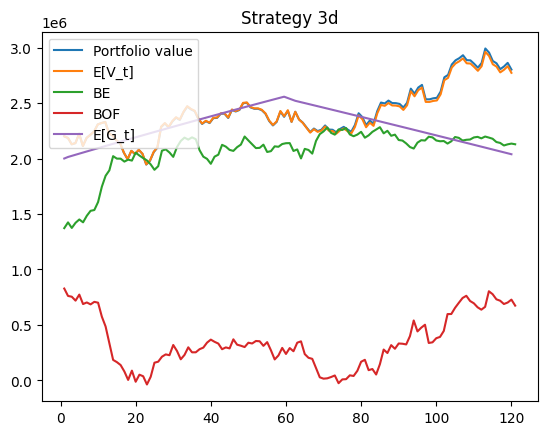

<Figure size 1200x800 with 0 Axes>

In [509]:
key = 34
plt.title("Strategy 3d")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_d[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_d[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_d[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_d.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

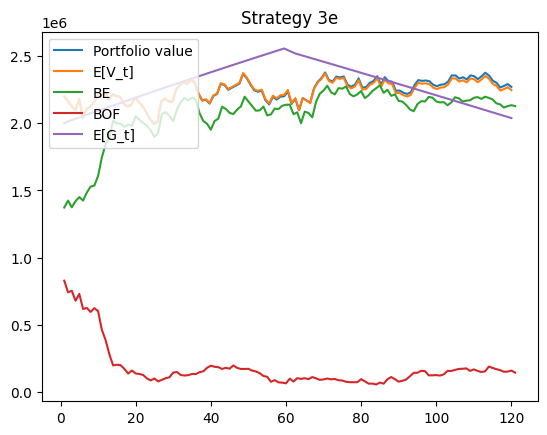

<Figure size 1200x800 with 0 Axes>

In [510]:
key = 34
plt.title("Strategy 3e")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_e[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_e[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_e[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_e.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))


### Scenario 208

<Figure size 1200x800 with 0 Axes>

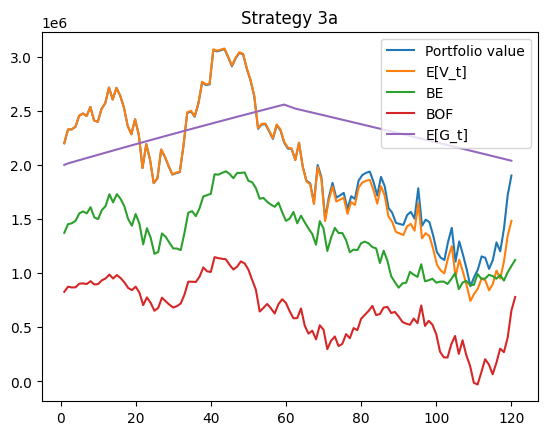

<Figure size 1200x800 with 0 Axes>

In [511]:
key = 207
plt.title("Strategy 3a")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_a[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_a[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_a[key,:], label = "BE")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_a.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper right")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper right")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

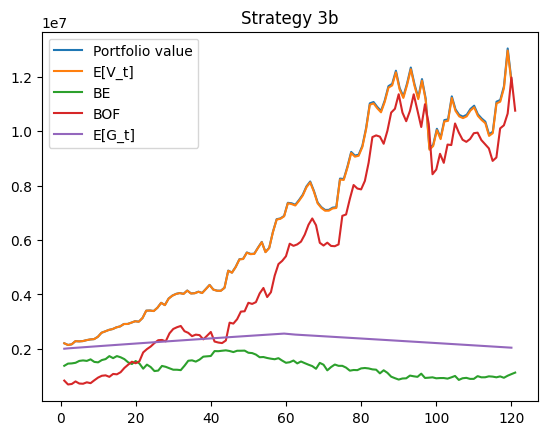

<Figure size 1200x800 with 0 Axes>

In [512]:
key = 207
plt.title("Strategy 3b")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_b[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_b[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_b[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_b.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

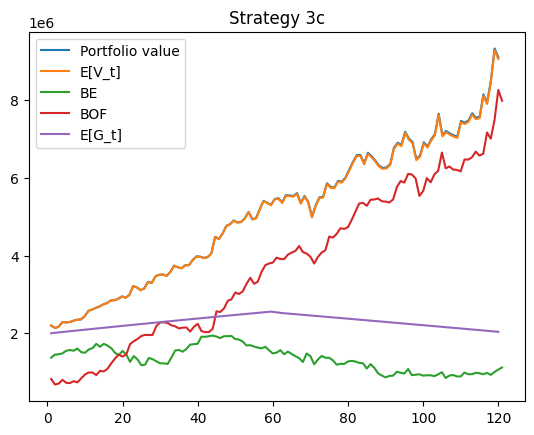

<Figure size 1200x800 with 0 Axes>

In [513]:
key = 207
plt.title("Strategy 3c")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_c[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_c[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_c[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_c.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

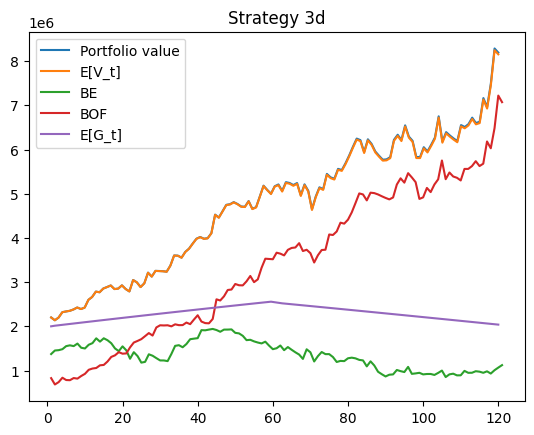

<Figure size 1200x800 with 0 Axes>

In [514]:
key = 207
plt.title("Strategy 3d")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_d[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_d[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_d[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_d.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

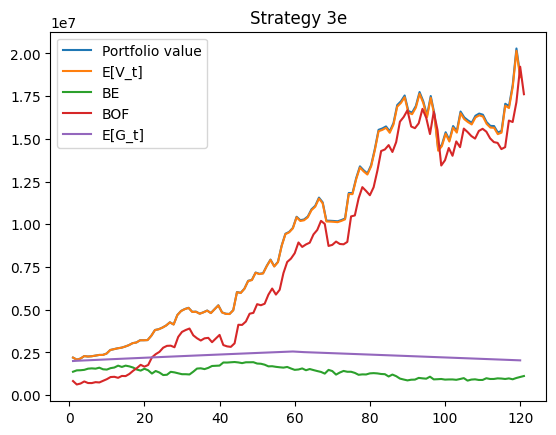

<Figure size 1200x800 with 0 Axes>

In [515]:
key = 207
plt.title("Strategy 3e")
plt.plot(np.linspace(1,12*10,12*10+1), portfolio_e[key,:12*30+1], label = "Portfolio value")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Vt_e[key,:12*10+1], label = "E[V_t]")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BE_e[key,:], label = "BE")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10+1,12*10+1), BOF_e.iloc[key,:-1], label = "BOF")
plt.legend(loc="upper left")
plt.plot(np.linspace(1,12*10,12*10+1), E_Gt[:12*10+1], label = "E[G_t]")
plt.legend(loc="upper left")
plt.figure(figsize=(12,8))

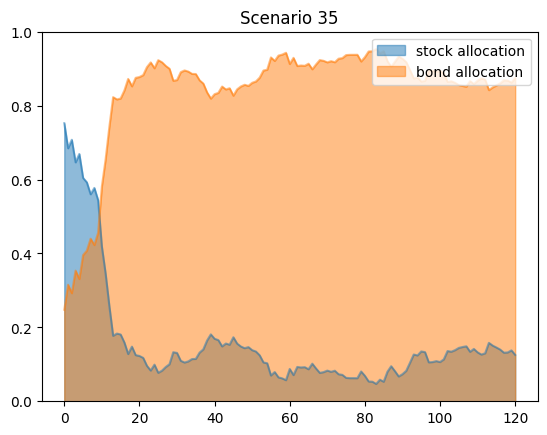

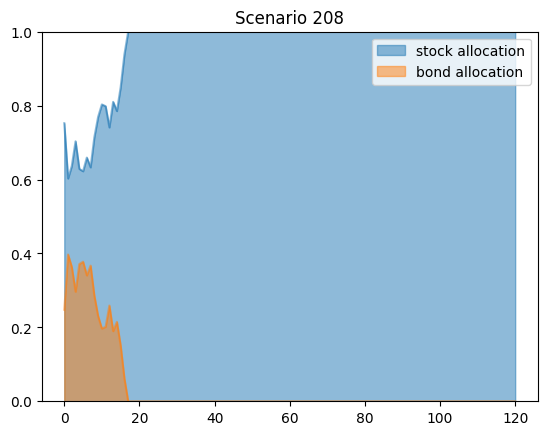

In [516]:
allocations = pd.DataFrame(CPPI_allocations)#, columns=["35: stocks", "35: bonds", "208: stocks", "2008: bonds"])
allocations.iloc[0,:].plot.area(stacked=False, label="stock allocation")
allocations.iloc[1,:].plot.area(stacked=False, label="bond allocation")
plt.legend(loc="upper right")
plt.title("Scenario 35")
plt.ylim([0, 1])  
plt.show()

allocations.iloc[2,:].plot.area(stacked=False, label="stock allocation")
allocations.iloc[3,:].plot.area(stacked=False, label="bond allocation")
plt.legend(loc="upper right")
plt.title("Scenario 208")
plt.ylim([0, 1])  
plt.show()

## What can be seen from the strategies
When we first look at strategy A, we see that it has the highest probability of insolvency. This probably due to the fact that the five year bond wont provide enough return to support the payments. This strategy however has the lowest SCR meaning less capital needs to be held as a buffer.

Our recommendation would be CM(50/50) that matches the first reserve's cashflow duration. This is because it has the lowest SCR of the non "only-bond" strategies and offers the second lowest probability of insolvency while also offering the second highest median BOF. It is also reasonable to keep a constant mix of bonds and stocks to ensure that the company keeps afloat even when times are bad. 

An other recommendation that also could be good is the CPPI(2) strategy. This also performs well when it is either a bull or bear market. This strategy tries to ensure that the portfolio value will never go below the obligations that the firm has, while also keeping the possibility to get higher retruns since we can rebalance the portfolio to buy more stocks when the market is going well. However, since we have set $m = 2$, there is a chance that the portfolio value will drop below the obligations' value, which makes it risky if the markets were to drop or interest rates were to sink rapidly.

Our final recommendation is therefore to choose one of these strategies based on the CFO's risk apetite.



In scenario 35, it seems like strategy A performed the best, that is the strategy with only a bond. It can also seems like that strategy B and E did not become insolvent. A performed the best since it seems like, in this scenario, that the interest rates fell a bit, but since A only consists of having bonds, it was affected in a positive way due to this. 

In scenario 208, we see that strategy E performed the best, followed by strategy B. In this scenario, it seemed like the stock pirces increased by a lot. Strategy A is not affected by this rise and therefore did not increase that much in BOF. When then looking at strategies B, C, and D, the reason why B performed so much better is because it doesn't have to rebalance sell of stocks to buy bonds. The reason why E performed the best was due to it enabling the portfolio to be converted mostly to stocks due to the market going so good.



# Creating a new file 
Creating a new file that simulates the prices one year into the future if the events of the 2008 financial crisis were to happen today. 

In [73]:
market_data = pd.read_csv("market_data_3.csv", sep=";", parse_dates=True) #index_col="Date",



# Konvertera Date till datetime om det inte redan är gjort
market_data['Date'] = pd.to_datetime(market_data['Date'])

# Filtrera data för 2008
data_2008 = market_data[(market_data['Date'] >= "2007-12-01") & (market_data['Date'] < "2009-01-01")]

# Extrahera månad och år från 'Date'
data_2008['Month'] = data_2008['Date'].dt.to_period('M')

# Gruppera efter 'Year-Month' och beräkna medelvärdet för varje månad
monthly_prices = data_2008.groupby('Month').nth([-1])

# Visa resultatet
monthly_prices = monthly_prices.drop(columns=['Date'])
#monthly_prices = monthly_prices.drop(columns=['Month'])
monthly_prices.set_index("Month")
#monthly_returns = monthly_prices.pct_change()
#print(monthly_returns)
print(monthly_prices)
#assets = monthly_prices.iloc[0:15].values
#print(assets)




            BA        CAT         KO        DIS        JPM        MMM  \
625  64.097229  46.277752  18.274683  27.171474  28.327162  42.055023   
628  56.453350  42.286083  17.393261  24.141199  28.569380  37.660999   
633  60.973278  46.390926  17.408155  27.280905  26.611963  39.348797   
637  54.109261  49.443893  18.263342  26.094046  27.960545  39.122944   
641  62.483082  52.994839  17.780834  27.238810  31.541258  39.057682   
646  61.242893  53.246105  17.160471  28.282579  28.379869  39.179867   
650  49.515228  47.518158  15.638569  26.573841  23.132891  35.113365   
654  47.228867  45.683300  15.704935  26.178211  26.375193  35.840809   
659  48.808369  45.845333  15.707959  27.230392  25.687790  36.424534   
663  43.418285  41.567394  15.944234  27.567093  32.194820  35.330780   
668  39.025848  25.009985  13.386109  21.809572  27.742189  32.710861   
672  31.975901  26.836630  14.360909  18.956059  21.292553  34.324871   
677  32.005886  29.245968  13.870670  19.385435  21

C:\Users\chril\AppData\Local\Temp\ipykernel_36216\2167274645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2008['Month'] = data_2008['Date'].dt.to_period('M')


In [74]:
returns = monthly_prices.iloc[:,0:15].pct_change().dropna()#(monthly_prices.iloc[:,0:15].diff()/monthly_prices.iloc[:,0:15]).dropna()  # diff() calculates the difference
returns

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
628,-0.119254,-0.086255,-0.048232,-0.111524,0.008551,-0.104483,-0.074719,-0.005280,0.011782,-0.104066,-0.177146,-0.089783,-0.038680,-0.018624,-0.064468
633,0.080065,0.097073,0.000856,0.130056,-0.068514,0.044816,-0.171048,-0.000667,0.031192,0.041047,-0.088662,-0.004460,0.019471,0.032012,0.046865
637,-0.112574,0.065810,0.049126,-0.043505,0.050676,-0.005740,0.026103,-0.079893,0.056020,-0.020572,-0.039164,-0.009450,0.008971,-0.004239,-0.061093
641,0.154758,0.071818,-0.026419,0.043871,0.128063,-0.001668,0.068793,-0.003415,0.106102,0.084957,0.298666,0.094203,0.042073,0.048973,0.108600
646,-0.019848,0.004741,-0.034889,0.038319,-0.100230,0.003128,-0.047125,-0.037287,0.005787,-0.035729,0.077656,0.039245,0.020875,0.016990,0.031457
650,-0.191494,-0.107575,-0.088686,-0.060417,-0.184884,-0.103791,-0.024364,-0.107438,-0.024940,-0.024898,-0.019590,-0.029580,-0.032249,-0.033030,-0.033683
654,-0.046175,-0.038614,0.004244,-0.014888,0.140160,0.020717,-0.053203,0.093171,0.009414,-0.056037,0.024667,0.038773,0.041359,0.035429,0.011699
659,0.033444,0.003547,0.000193,0.040193,-0.026062,0.016287,0.047357,0.028342,0.043608,-0.015684,-0.113981,-0.068733,-0.053237,-0.056015,-0.064463
663,-0.110434,-0.093312,0.015042,0.012365,0.253312,-0.030028,0.004031,-0.023548,0.027763,0.007999,-0.019120,0.023571,0.004738,-0.016205,-0.018103
668,-0.101166,-0.398327,-0.160442,-0.208855,-0.138303,-0.074154,-0.185037,-0.050911,-0.080711,-0.080968,-0.051031,0.150351,0.127226,0.051734,-0.095258


### Apply the returns to 2023

In [132]:
last_price = market_data.iloc[-1,1:16].values
real_returns = returns + 1
names = monthly_prices.columns[:15]
assets = np.zeros((13,15))
assets[0,:] = market_data.iloc[-1,1:16]
for i in range(12):
    #print(last_price)
    
    assets[i+1,:] = assets[i,:]*real_returns.iloc[i,:].values
    #last_price = assets[i,:]
assets = pd.DataFrame(assets)
assets.columns = names
assets.insert(0, "Scenario", [1 for i in range(13)])
assets.insert(1, "Period", [i for i in range(13)])
assets

,Scenario,Period,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
0,1,0,260.660004,292.048218,57.617237,89.875359,167.150925,88.812355,373.995972,27.552946,52.042637,97.476494,0.038263,0.039084,0.040465,0.041383,0.041910
1,1,1,229.575142,266.857717,54.838250,79.852086,168.580188,79.532997,346.051437,27.407470,52.655783,87.332466,0.031485,0.035575,0.038900,0.040612,0.039208
2,1,2,247.956037,292.762436,54.885210,90.237322,157.030002,83.097310,286.860088,27.389193,54.298200,90.917237,0.028693,0.035416,0.039657,0.041912,0.041046
3,1,3,220.042586,312.029007,57.581480,86.311536,164.987616,82.620351,294.347872,25.201000,57.339980,89.046883,0.027570,0.035082,0.040013,0.041735,0.038538
4,1,4,254.095857,334.438203,56.060209,90.098084,186.116437,82.482530,314.596857,25.114948,63.423845,96.612003,0.035804,0.038386,0.041696,0.043779,0.042723
5,1,5,249.052463,336.023888,54.104300,93.550572,167.461938,82.740562,299.771520,24.178483,63.790872,93.160158,0.038584,0.039893,0.042567,0.044522,0.044067
6,1,6,201.360336,299.876134,49.305979,87.898561,136.500935,74.152870,292.467828,21.580804,62.199946,90.840621,0.037828,0.038713,0.041194,0.043052,0.042583
7,1,7,192.062539,288.296769,49.515221,86.589932,155.632882,75.689095,276.907560,23.591504,62.785506,85.750208,0.038761,0.040214,0.042898,0.044577,0.043081
8,1,8,198.485797,289.319322,49.524756,90.070242,151.576705,76.921813,290.020970,24.260143,65.523458,84.405314,0.034343,0.037450,0.040614,0.042080,0.040304
9,1,9,176.566298,262.322237,50.269693,91.183950,189.972933,74.612009,291.189952,23.688868,67.342619,85.080470,0.033687,0.038333,0.040807,0.041398,0.039574


### Calculate NS-parameters

In [133]:
#calculate NS parametrar
lambd = 0.7308

def f2_calc (T):
    f2_v = (1 - np.exp(-lambd*T))/(lambd*T)
    return f2_v

def f3_calc (T):
    f3_v = (1 - np.exp(-lambd*T))/(lambd*T) - np.exp(-lambd*T)
    return f3_v



f1 = np.ones(5)

T = np.array((5,10,15,20,30))
f2 = f2_calc(T)
f3 = f3_calc(T)


M = np.column_stack([f1, f2, f3])

# Print the result
print(M)

[[1.         0.26658802 0.24070065]
 [1.         0.13674464 0.13607449]
 [1.         0.09122265 0.0912053 ]
 [1.         0.06841814 0.06841769]
 [1.         0.04561211 0.04561211]]


In [134]:
R = assets.iloc[:,-5:]
beta1 = []
beta2 = []
beta3 = []
for i in range(0,13):
    r = R.iloc[i,:]
    betas = np.linalg.inv((np.transpose(M) @ M)) @ (np.transpose(M) @ r)
    beta1.append(betas[0])
    beta2.append(betas[1])
    beta3.append(betas[2])

beta1

assets["b1"] =  beta1
assets["b2"] =  beta2
assets["b3"] =  beta3
assets

,Scenario,Period,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30,b1,b2,b3
0,1,0,260.660004,292.048218,57.617237,89.875359,167.150925,88.812355,373.995972,27.552946,52.042637,97.476494,0.038263,0.039084,0.040465,0.041383,0.041910,0.043486,0.102582,-0.135316
1,1,1,229.575142,266.857717,54.838250,79.852086,168.580188,79.532997,346.051437,27.407470,52.655783,87.332466,0.031485,0.035575,0.038900,0.040612,0.039208,0.042536,0.003829,-0.050220
2,1,2,247.956037,292.762436,54.885210,90.237322,157.030002,83.097310,286.860088,27.389193,54.298200,90.917237,0.028693,0.035416,0.039657,0.041912,0.041046,0.045346,-0.008296,-0.060061
3,1,3,220.042586,312.029007,57.581480,86.311536,164.987616,82.620351,294.347872,25.201000,57.339980,89.046883,0.027570,0.035082,0.040013,0.041735,0.038538,0.042890,-0.155758,0.108724
4,1,4,254.095857,334.438203,56.060209,90.098084,186.116437,82.482530,314.596857,25.114948,63.423845,96.612003,0.035804,0.038386,0.041696,0.043779,0.042723,0.046313,0.103636,-0.158499
5,1,5,249.052463,336.023888,54.104300,93.550572,167.461938,82.740562,299.771520,24.178483,63.790872,93.160158,0.038584,0.039893,0.042567,0.044522,0.044067,0.047169,0.150858,-0.202782
6,1,6,201.360336,299.876134,49.305979,87.898561,136.500935,74.152870,292.467828,21.580804,62.199946,90.840621,0.037828,0.038713,0.041194,0.043052,0.042583,0.045492,0.153830,-0.202245
7,1,7,192.062539,288.296769,49.515221,86.589932,155.632882,75.689095,276.907560,23.591504,62.785506,85.750208,0.038761,0.040214,0.042898,0.044577,0.043081,0.045970,0.079234,-0.117765
8,1,8,198.485797,289.319322,49.524756,90.070242,151.576705,76.921813,290.020970,24.260143,65.523458,84.405314,0.034343,0.037450,0.040614,0.042080,0.040304,0.043365,0.004840,-0.042919
9,1,9,176.566298,262.322237,50.269693,91.183950,189.972933,74.612009,291.189952,23.688868,67.342619,85.080470,0.033687,0.038333,0.040807,0.041398,0.039574,0.041563,-0.140848,0.123198


In [ ]:



r5s = np.zeros(13)
r10s = np.zeros(13)
r15s = np.zeros(13)
r20s = np.zeros(13)
r30s = np.zeros(13)


for i in range(13):

    r5 = assets["Y05"].iloc[i]
    r10 = assets["Y10"].iloc[i]
    r15 = assets["Y15"].iloc[i]
    r20 = assets["Y20"].iloc[i]
    r30 = assets["Y30"].iloc[i]

    r5s[i] = 100*np.exp(-r5*5)
    r10s[i] = 100*np.exp(-r10*10)
    r15s[i] = 100*np.exp(-r10*15)
    r20s[i] = 100*np.exp(-r10*20)
    r30s[i] = 100*np.exp(-r10*30)


assets["ZCB05"] = r5s
assets["ZCB10"] = r10s
assets["ZCB15"] = r15s
assets["ZCB05"] = r20s
assets["ZCB05"] = r30s

In [152]:
assets

,Scenario,Period,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,...,Y20,Y30,b1,b2,b3,ZCB05,ZCB10,ZCB15,ZCB20,ZCB30
0,1,0,260.660004,292.048218,57.617237,89.875359,167.150925,88.812355,373.995972,27.552946,...,0.041383,0.041910,0.043486,0.102582,-0.135316,30.958580,67.648839,55.640435,43.826532,28.371347
1,1,1,229.575142,266.857717,54.838250,79.852086,168.580188,79.532997,346.051437,27.407470,...,0.040612,0.039208,0.042536,0.003829,-0.050220,34.395381,70.064825,58.647576,45.510188,29.742593
2,1,2,247.956037,292.762436,54.885210,90.237322,157.030002,83.097310,286.860088,27.389193,...,0.041912,0.041046,0.045346,-0.008296,-0.060061,34.559501,70.176088,58.787330,44.335586,28.172003
3,1,3,220.042586,312.029007,57.581480,86.311536,164.987616,82.620351,294.347872,25.201000,...,0.041735,0.038538,0.042890,-0.155758,0.108724,34.908235,70.411343,59.083191,45.228559,29.453914
4,1,4,254.095857,334.438203,56.060209,90.098084,186.116437,82.482530,314.596857,25.114948,...,0.043779,0.042723,0.046313,0.103636,-0.158499,31.613327,68.122420,56.225730,42.690665,26.865713
5,1,5,249.052463,336.023888,54.104300,93.550572,167.461938,82.740562,299.771520,24.178483,...,0.044522,0.044067,0.047169,0.150858,-0.202782,30.216375,67.103853,54.969423,41.797666,26.079590
6,1,6,201.360336,299.876134,49.305979,87.898561,136.500935,74.152870,292.467828,21.580804,...,0.043052,0.042583,0.045492,0.153830,-0.202245,31.305215,67.900384,55.951063,43.016238,27.293795
7,1,7,192.062539,288.296769,49.515221,86.589932,155.632882,75.689095,276.907560,23.591504,...,0.044577,0.043081,0.045970,0.079234,-0.117765,29.926791,66.888796,54.705384,42.034436,26.543589
8,1,8,198.485797,289.319322,49.524756,90.070242,151.576705,76.921813,290.020970,24.260143,...,0.042080,0.040304,0.043365,0.004840,-0.042919,32.514139,68.763412,57.021171,44.255308,28.683603
9,1,9,176.566298,262.322237,50.269693,91.183950,189.972933,74.612009,291.189952,23.688868,...,0.041398,0.039574,0.041563,-0.140848,0.123198,31.664397,68.159083,56.271126,44.614848,29.442448


In [185]:
assets.to_csv("OwnScenario2.csv", index=False)